In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [7]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

,interfere journal,isolated journal
0,360.0,191.0
1,522.0,320.0
2,985.0,689.0
3,1412.0,1099.0
4,1636.0,1282.0


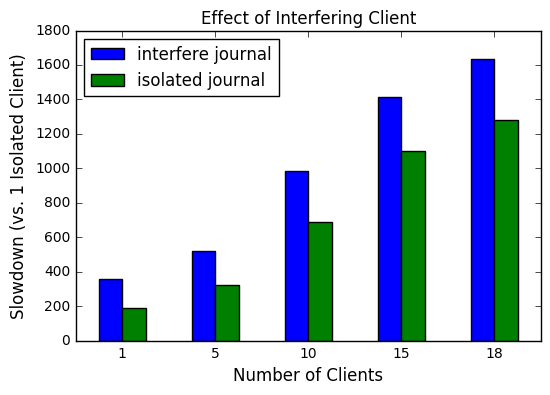

In [58]:
norm = np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1-nolog/*isolated*")))
mean = pd.DataFrame(columns=["interfere journal", "isolated journal"])
stds = pd.DataFrame(columns=["interfere journal", "isolated journal"])
clients = [1, 5, 10, 15, 18]
for i in clients:
    j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*interfere*"))
    j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))    
    mean.loc[len(mean)] = [np.max(j0), np.max(j1)]
    stds.loc[len(stds)] = [np.std(j0), np.std(j1)]    
fig, ax = plt.subplots(1, 1)
mean.plot.bar(ax=ax)
ax.set_ylabel("Slowdown (vs. 1 Isolated Client)", fontsize=12)
ax.set_title("Effect of Interfering Client", fontsize=12)
ax.set_xlabel("Number of Clients", fontsize=12)
x = ax.set_xticklabels(clients, rotation=0)
mean

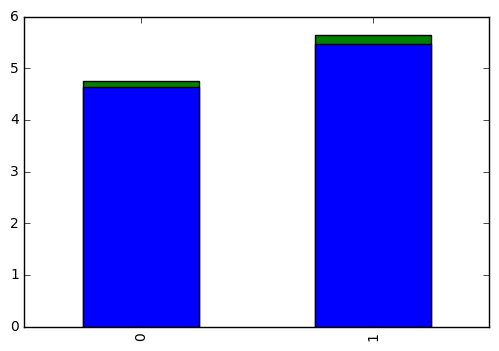

In [65]:
# get the performance
df = pd.read_csv("../results/summary.txt", names=['job', 'nfiles', '# of Clients', 'time', 'runtime'])
df['runtime'] = df['runtime'].apply(to_seconds)

# add on the time to create
with open('../../cudele-mechanisms/results/summary.txt') as f:
    df_create = pd.read_csv(f, names=['job', 'nfiles', 'time', 'runtime'])
    df_create['runtime'] = df_create['runtime'].apply(to_seconds)

df_create = df_create[df_create['job'] == 'create']
df_create = df_create[df_create['nfiles'] == 100000]
df['runtime+create'] = df['runtime'] + float(df_create['runtime'])

# normalize
df['runtime+create'] = 1636/df['runtime+create']
df['runtime'] = 1636/df['runtime']
fig, ax = plt.subplots(1, 1)
df['runtime'].plot.bar(ax=ax, color='green')
df['runtime+create'].plot.bar(ax=ax, color='blue')